---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit16_Example_Colorectal_Histology'
SOURCE_DATA_DIR = 'colorectal_histology'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\data\colorectal_histology
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


## 1. 載入 Colorectal Histology 資料集

In [2]:
# 下載 TensorFlow Datasets 中的 colorectal_histology（僅在 DATA_DIR 無資料時下載）
dataset_name = 'colorectal_histology'

# 若 DATA_DIR 有任一檔案則視為已下載
if DATA_DIR.exists() and any(DATA_DIR.rglob('*')):
    print(f"在 {DATA_DIR} 中發現現有檔案，將嘗試不重複下載並從該目錄載入...")
    (ds_train, ds_test), ds_info = tfds.load(
        dataset_name,
        split=['train[:80%]', 'train[80%:]'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        download=False,
        data_dir=str(DATA_DIR)
    )
else:
    print(f"在 {DATA_DIR} 未發現資料，開始下載數據集（會儲存至該目錄）...")
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    (ds_train, ds_test), ds_info = tfds.load(
        dataset_name,
        split=['train[:80%]', 'train[80%:]'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        data_dir=str(DATA_DIR)
    )

在 d:\MyGit\CHE-AI-COURSE\Part_4\data\colorectal_histology 未發現資料，開始下載數據集（會儲存至該目錄）...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling d:\MyGit\CHE-AI-COURSE\Part_4\data\colorectal_histology\colorectal_histology\2.0.0.incompleteXZCEAE\…

Dataset colorectal_histology downloaded and prepared to d:\MyGit\CHE-AI-COURSE\Part_4\data\colorectal_histology\colorectal_histology\2.0.0. Subsequent calls will reuse this data.


In [5]:
# 數據集資訊
print("="*60)
print("【數據集資訊】")
print("="*60)
print(f"數據集名稱: {ds_info.name}")
print(f"數據集描述: {ds_info.description}")
print(f"影像形狀: {ds_info.features['image'].shape}")
print(f"類別數量: {ds_info.features['label'].num_classes}")
print(f"類別名稱: {ds_info.features['label'].names}")
print(f"總樣本數: {ds_info.splits['train'].num_examples}")
print(f"訓練集大小: {tf.data.experimental.cardinality(ds_train).numpy()}")
print(f"驗證集大小: {tf.data.experimental.cardinality(ds_test).numpy()}")
print("="*60)

# 類別名稱
class_names = ds_info.features['label'].names
num_classes = ds_info.features['label'].num_classes

# Map English class names to Chinese labels (中文註解)
class_labels_map = {
    'tumor': '腫瘤上皮',
    'stroma': '簡單基質',
    'complex': '複雜基質',
    'lympho': '免疫細胞',
    'debris': '碎屑',
    'mucosa': '正常黏膜',
    'adipose': '脂肪組織',
    'empty': '背景'
}

# Build class_names_zh in the same order as class_names (確保順序一致)
class_names_zh = [class_labels_map[ename] for ename in class_names]

# Sanity check (長度檢查)
if len(class_names_zh) != num_classes:
    raise ValueError(f"Mismatch between num_classes ({num_classes}) and class_names_zh length ({len(class_names_zh)})")

# Print mapping (主要以英文為主)
print("Class name mapping (EN -> ZH):")
for en, zh in zip(class_names, class_names_zh):
    print(f"{en:10s} -> {zh}")

print("\n【類別詳細說明】")
print("="*60)
for i, (en_name, zh_name) in enumerate(zip(class_names, class_names_zh)):
    print(f"類別 {i+1} ({en_name:15s}): {zh_name}")
print("="*60)

【數據集資訊】
數據集名稱: colorectal_histology
數據集描述: Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
影像形狀: (150, 150, 3)
類別數量: 8
類別名稱: ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']
總樣本數: 5000
訓練集大小: 4000
驗證集大小: 1000
Class name mapping (EN -> ZH):
tumor      -> 腫瘤上皮
stroma     -> 簡單基質
complex    -> 複雜基質
lympho     -> 免疫細胞
debris     -> 碎屑
mucosa     -> 正常黏膜
adipose    -> 脂肪組織
empty      -> 背景

【類別詳細說明】
類別 1 (tumor          ): 腫瘤上皮
類別 2 (stroma         ): 簡單基質
類別 3 (complex        ): 複雜基質
類別 4 (lympho         ): 免疫細胞
類別 5 (debris         ): 碎屑
類別 6 (mucosa         ): 正常黏膜
類別 7 (adipose        ): 脂肪組織
類別 8 (empty          ): 背景


## 2. 資料視覺化

正在生成樣本視覺化...


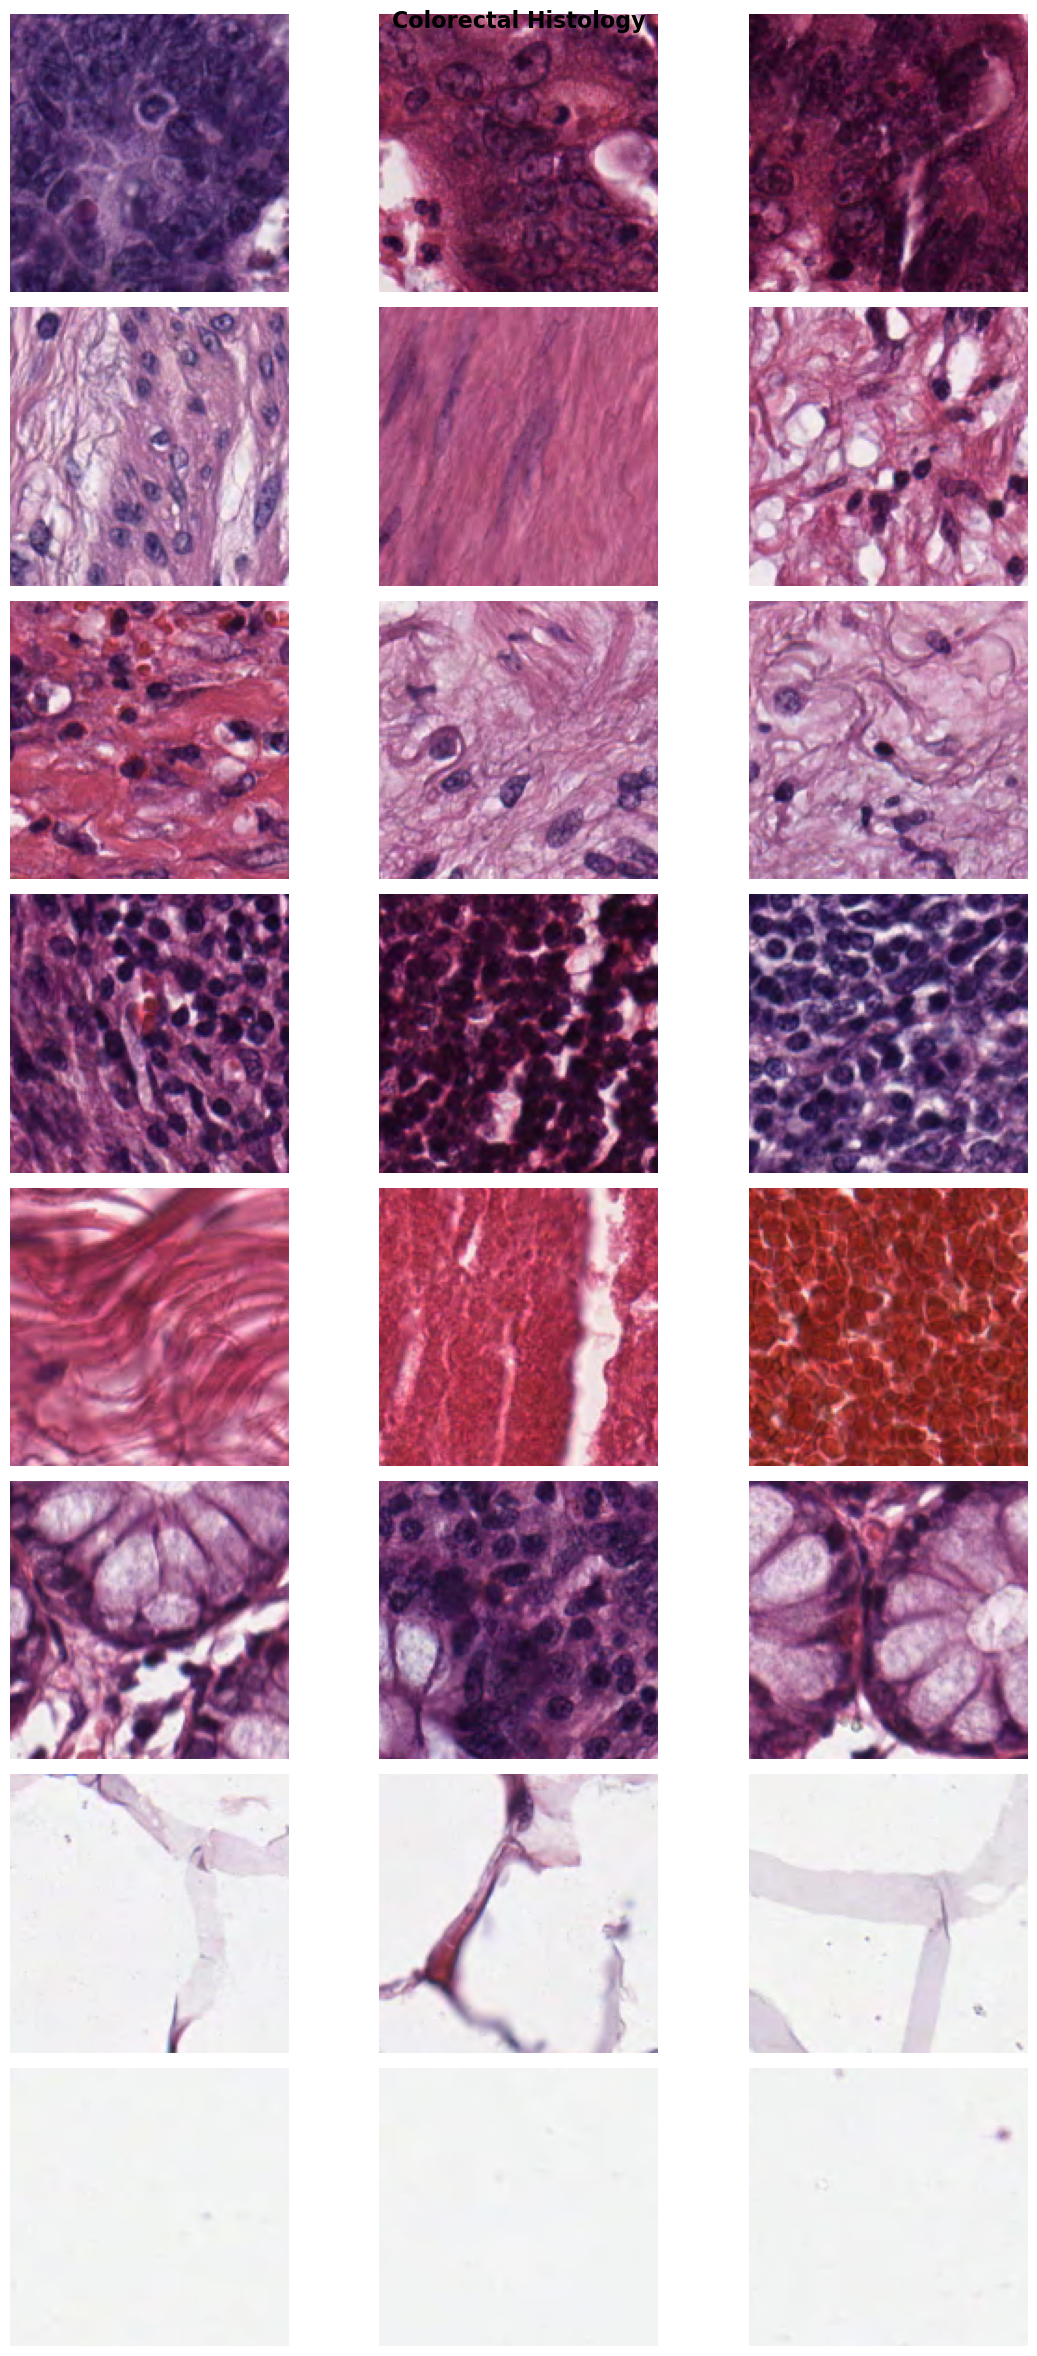

✓ 樣本圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\figs\sample_images.png


In [9]:
# 顯示每個類別的樣本
print("正在生成樣本視覺化...")

# 收集每個類別的第一個樣本
samples_per_class = {i: [] for i in range(num_classes)}
for image, label in ds_train.take(1000):
    label_int = label.numpy()
    if len(samples_per_class[label_int]) < 3:
        samples_per_class[label_int].append(image.numpy())
    if all(len(v) >= 3 for v in samples_per_class.values()):
        break

# 繪製樣本
fig, axes = plt.subplots(num_classes, 3, figsize=(12, 24))
fig.suptitle('Colorectal Histology', fontsize=16, fontweight='bold')

for i in range(num_classes):
    for j in range(3):
        ax = axes[i, j]
        if len(samples_per_class[i]) > j:
            ax.imshow(samples_per_class[i][j].astype('uint8'))
        ax.axis('off')
        if j == 0:
            ax.set_ylabel(f'{class_names_zh[i]}\n({class_names[i]})', 
                         fontsize=12, fontweight='bold', rotation=0, 
                         ha='right', va='center', labelpad=40)

plt.tight_layout()
plt.savefig(FIG_DIR / 'sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 樣本圖已儲存至: {FIG_DIR / 'sample_images.png'}")

## 3. 資料預處理與增強

In [10]:
# 設定超參數
BATCH_SIZE = 32
IMG_SIZE = 150
AUTOTUNE = tf.data.AUTOTUNE

# 正規化函數
def normalize_img(image, label):
    """將影像正規化到 [0, 1] 範圍"""
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 資料增強（僅用於訓練集）
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment(image, label):
    """應用資料增強"""
    image = data_augmentation(image, training=True)
    return image, label

# 準備訓練集（含增強）
ds_train_prepared = (
    ds_train
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# 準備驗證集（不含增強）
ds_test_prepared = (
    ds_test
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("✓ 資料預處理完成")
print(f"  - 訓練集批次數: {tf.data.experimental.cardinality(ds_train_prepared).numpy()}")
print(f"  - 驗證集批次數: {tf.data.experimental.cardinality(ds_test_prepared).numpy()}")
print(f"  - 批次大小: {BATCH_SIZE}")
print(f"  - 影像大小: {IMG_SIZE}x{IMG_SIZE}x3")

✓ 資料預處理完成
  - 訓練集批次數: 125
  - 驗證集批次數: 32
  - 批次大小: 32
  - 影像大小: 150x150x3


## 4. Baseline 模型：傳統機器學習

在訓練 CNN 之前，先用傳統機器學習方法建立 baseline，以驗證：
1. 數據集是否可學習
2. CNN 是否真的必要
3. 建立性能下限作為比較基準

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import time

print("正在準備 Baseline 數據...")

# 轉換數據為 NumPy 陣列（用於傳統 ML）
X_train, y_train = [], []
for images, labels in ds_train.map(normalize_img).batch(100).take(40):
    X_train.append(images.numpy().reshape(-1, IMG_SIZE * IMG_SIZE * 3))
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

X_test, y_test = [], []
for images, labels in ds_test.map(normalize_img).batch(100):
    X_test.append(images.numpy().reshape(-1, IMG_SIZE * IMG_SIZE * 3))
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(f"✓ 訓練集形狀: {X_train.shape}")
print(f"✓ 驗證集形狀: {X_test.shape}")

# ========================================
# Random Forest
# ========================================
print("\n" + "="*60)
print("訓練 Random Forest...")
print("="*60)

rf_start = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)
rf_time = time.time() - rf_start

rf_train_acc = accuracy_score(y_train, rf_model.predict(X_train))
rf_test_acc = accuracy_score(y_test, rf_model.predict(X_test))

print(f"訓練時間: {rf_time:.2f} 秒")
print(f"訓練準確率: {rf_train_acc:.4f}")
print(f"驗證準確率: {rf_test_acc:.4f}")

# ========================================
# MLP
# ========================================
print("\n" + "="*60)
print("訓練 MLP...")
print("="*60)

mlp_start = time.time()
mlp_model = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    max_iter=20,
    random_state=42,
    verbose=True
)
mlp_model.fit(X_train, y_train)
mlp_time = time.time() - mlp_start

mlp_train_acc = accuracy_score(y_train, mlp_model.predict(X_train))
mlp_test_acc = accuracy_score(y_test, mlp_model.predict(X_test))

print(f"\n訓練時間: {mlp_time:.2f} 秒")
print(f"訓練準確率: {mlp_train_acc:.4f}")
print(f"驗證準確率: {mlp_test_acc:.4f}")

# ========================================
# 結果比較
# ========================================
print("\n" + "="*60)
print("Baseline 模型性能比較")
print("="*60)
print(f"{'模型':<20} {'訓練準確率':<15} {'驗證準確率':<15} {'時間(秒)'}")
print("-"*60)
print(f"{'Random Forest':<20} {rf_train_acc:<15.4f} {rf_test_acc:<15.4f} {rf_time:.2f}")
print(f"{'MLP':<20} {mlp_train_acc:<15.4f} {mlp_test_acc:<15.4f} {mlp_time:.2f}")
print("="*60)

best_baseline = "Random Forest" if rf_test_acc > mlp_test_acc else "MLP"
best_baseline_acc = max(rf_test_acc, mlp_test_acc)
print(f"\n✓ 最佳 Baseline: {best_baseline} (驗證準確率: {best_baseline_acc:.4f})")

正在準備 Baseline 數據...
✓ 訓練集形狀: (4000, 67500)
✓ 驗證集形狀: (1000, 67500)

訓練 Random Forest...
訓練時間: 4.26 秒
訓練準確率: 1.0000
驗證準確率: 0.7260

訓練 MLP...
Iteration 1, loss = 11.65730879
Iteration 2, loss = 6.59562920
Iteration 3, loss = 3.84861178
Iteration 4, loss = 2.13393092
Iteration 5, loss = 2.42964924
Iteration 6, loss = 3.11376480
Iteration 7, loss = 2.47753298
Iteration 8, loss = 1.74105129
Iteration 9, loss = 1.48628429
Iteration 10, loss = 1.34550697
Iteration 11, loss = 1.38603297
Iteration 12, loss = 1.57561126
Iteration 13, loss = 1.35985918
Iteration 14, loss = 1.85695289
Iteration 15, loss = 1.21884740
Iteration 16, loss = 1.92192536
Iteration 17, loss = 1.40652443
Iteration 18, loss = 0.94097165
Iteration 19, loss = 1.10302651
Iteration 20, loss = 1.24708303


c:\Users\Yao-ChenChuang\miniconda3\envs\PY310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



訓練時間: 197.14 秒
訓練準確率: 0.5570
驗證準確率: 0.4620

Baseline 模型性能比較
模型                   訓練準確率           驗證準確率           時間(秒)
------------------------------------------------------------
Random Forest        1.0000          0.7260          4.26
MLP                  0.5570          0.4620          197.14

✓ 最佳 Baseline: Random Forest (驗證準確率: 0.7260)


## 5. 建立簡單 CNN 模型

In [12]:
# 建立簡單的 CNN 模型
def create_simple_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=8):
    model = tf.keras.Sequential([
        # 輸入層
        tf.keras.layers.Input(shape=input_shape),
        
        # 第一組卷積層
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # 第二組卷積層
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # 第三組卷積層
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # 第四組卷積層
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        
        # 全連接層
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        
        # 輸出層
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# 建立模型
simple_cnn = create_simple_cnn(num_classes=num_classes)

# 編譯模型
simple_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 顯示模型架構
print("="*60)
print("簡單 CNN 模型架構")
print("="*60)
simple_cnn.summary()

# 計算參數量
total_params = simple_cnn.count_params()
print(f"\n✓ 總參數量: {total_params:,}")

簡單 CNN 模型架構
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                          

## 6. 訓練簡單 CNN 模型

In [13]:
# 設定回調函數
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(MODEL_DIR / 'simple_cnn_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# 訓練模型
print("\n" + "="*60)
print("開始訓練簡單 CNN 模型")
print("="*60)

history_simple = simple_cnn.fit(
    ds_train_prepared,
    validation_data=ds_test_prepared,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

print("\n✓ 訓練完成！")


開始訓練簡單 CNN 模型
Epoch 1/30
123/125 [============================>.] - ETA: 0s - loss: 1.0934 - accuracy: 0.5800
Epoch 1: val_accuracy improved from -inf to 0.23900, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\models\simple_cnn_best.h5
125/125 [==============================] - 9s 28ms/step - loss: 1.0939 - accuracy: 0.5803 - val_loss: 3.6113 - val_accuracy: 0.2390 - lr: 0.0010
Epoch 2/30
124/125 [============================>.] - ETA: 0s - loss: 0.8371 - accuracy: 0.6830
Epoch 2: val_accuracy did not improve from 0.23900
125/125 [==============================] - 3s 24ms/step - loss: 0.8368 - accuracy: 0.6833 - val_loss: 6.4680 - val_accuracy: 0.1260 - lr: 0.0010
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.6990
Epoch 3: val_accuracy improved from 0.23900 to 0.49200, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\models\simple_cnn_best.h5
125/125 [

## 7. 繪製訓練歷史

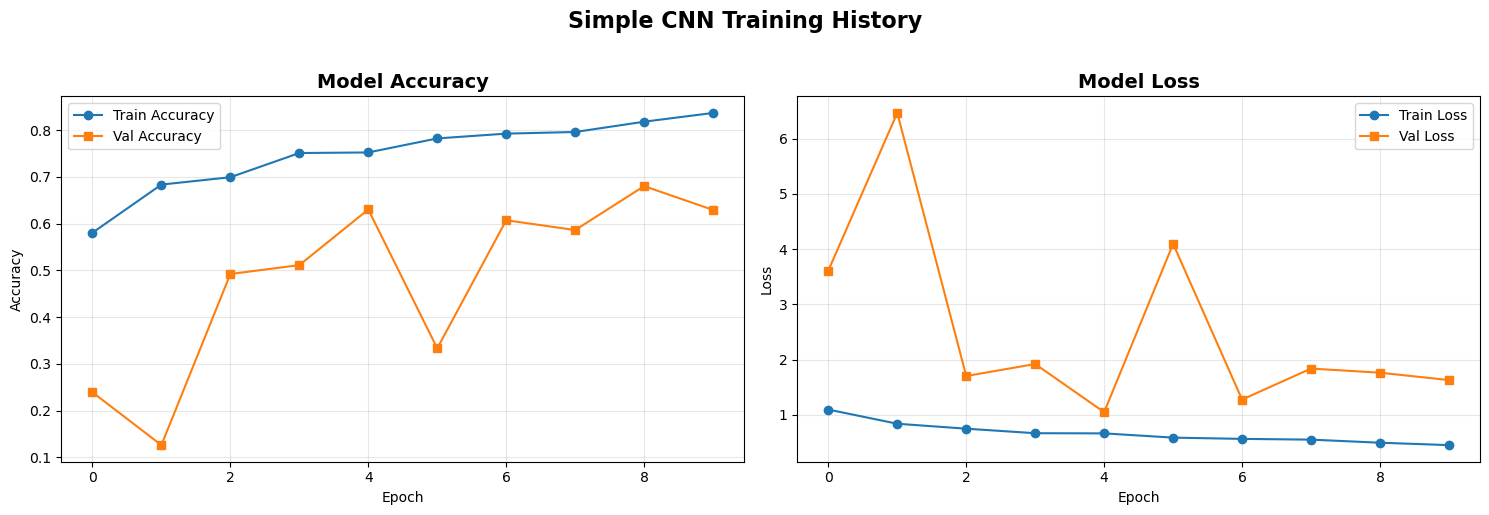

✓ 訓練歷史圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\figs\simple_cnn_history.png


In [14]:
# 繪製訓練歷史
def plot_training_history(history, title='Model Training History'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # 準確率
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 損失
    axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
    axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig

# 繪製簡單 CNN 訓練歷史
fig = plot_training_history(history_simple, 'Simple CNN Training History')
plt.savefig(FIG_DIR / 'simple_cnn_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 訓練歷史圖已儲存至: {FIG_DIR / 'simple_cnn_history.png'}")

## 8. 評估模型並繪製混淆矩陣

正在評估模型...

✓ 驗證集準確率: 0.6300


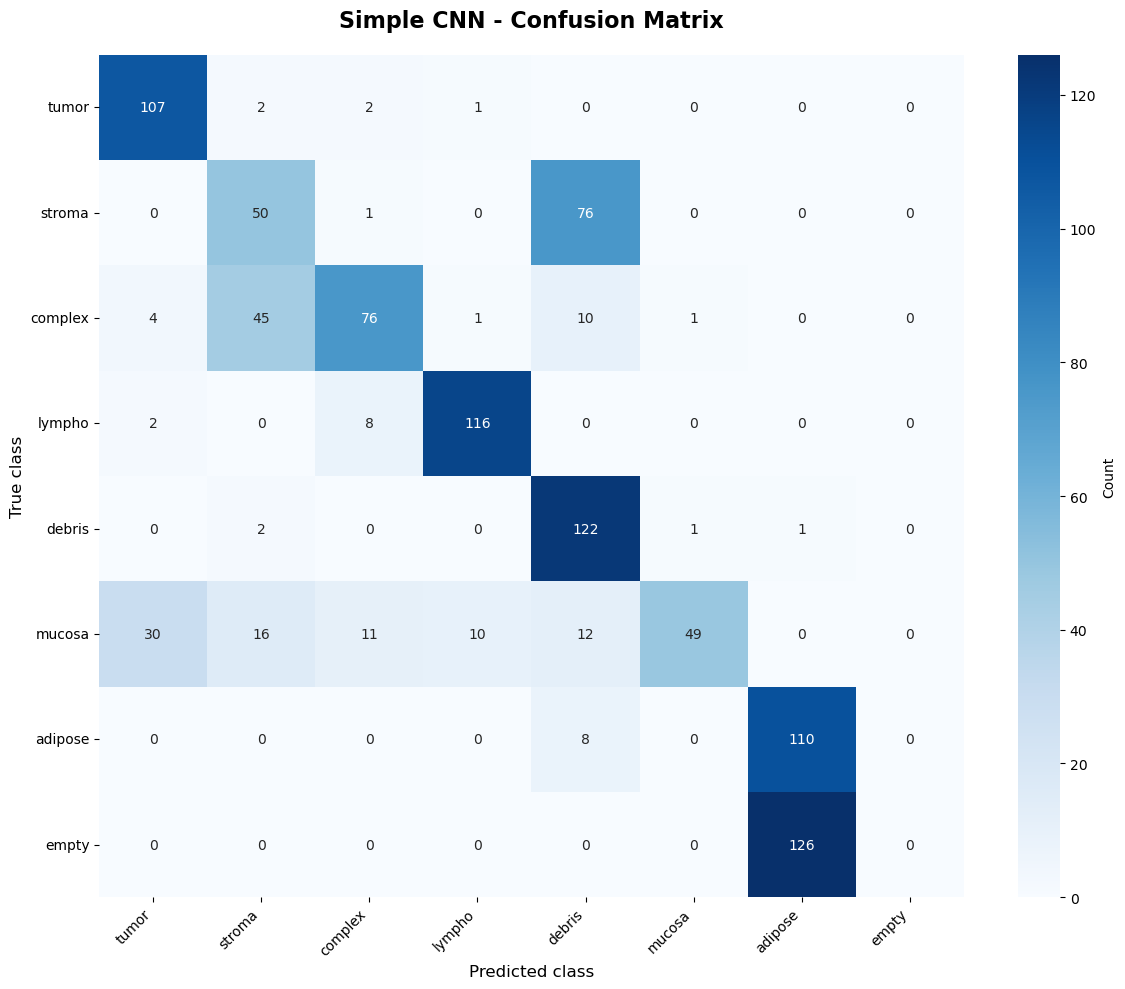

✓ 混淆矩陣已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\figs\simple_cnn_confusion_matrix.png

分類報告
              precision    recall  f1-score   support

        腫瘤上皮     0.7483    0.9554    0.8392       112
        簡單基質     0.4348    0.3937    0.4132       127
        複雜基質     0.7755    0.5547    0.6468       137
        免疫細胞     0.9062    0.9206    0.9134       126
          碎屑     0.5351    0.9683    0.6893       126
        正常黏膜     0.9608    0.3828    0.5475       128
        脂肪組織     0.4641    0.9322    0.6197       118
          背景     0.0000    0.0000    0.0000       126

    accuracy                         0.6300      1000
   macro avg     0.6031    0.6385    0.5836      1000
weighted avg     0.6046    0.6300    0.5802      1000



c:\Users\Yao-ChenChuang\miniconda3\envs\PY310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Yao-ChenChuang\miniconda3\envs\PY310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Yao-ChenChuang\miniconda3\envs\PY310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

In [18]:
# 在驗證集上預測
print("正在評估模型...")

y_true = []
y_pred = []

for images, labels in ds_test_prepared:
    predictions = simple_cnn.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 計算準確率
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✓ 驗證集準確率: {accuracy:.4f}")

# 繪製混淆矩陣
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Simple CNN - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / 'simple_cnn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 混淆矩陣已儲存至: {FIG_DIR / 'simple_cnn_confusion_matrix.png'}")

# 分類報告
print("\n" + "="*60)
print("分類報告")
print("="*60)
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_names_zh,
    digits=4
))

## 9. 遷移學習：使用 EfficientNetB0

醫學影像數據稀缺，使用預訓練模型可以顯著提升性能。
我們使用 EfficientNetB0 作為特徵提取器，並在其上添加自定義分類頭。

In [19]:
# 建立遷移學習模型（EfficientNetB0）
def create_transfer_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=8):
    # 載入預訓練的 EfficientNetB0（不包含頂層）
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    
    # 凍結預訓練層
    base_model.trainable = False
    
    # 建立新模型
    inputs = tf.keras.Input(shape=input_shape)
    
    # 預處理（EfficientNet 要求）
    x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
    
    # 預訓練基礎模型
    x = base_model(x, training=False)
    
    # 全局平均池化
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # 自定義分類頭
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # 輸出層
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model, base_model

# 建立模型
transfer_model, base_model = create_transfer_model(num_classes=num_classes)

# 編譯模型
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 顯示模型架構
print("="*60)
print("遷移學習模型架構（EfficientNetB0）")
print("="*60)
transfer_model.summary()

# 計算參數量
total_params = transfer_model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in transfer_model.trainable_weights])
non_trainable_params = total_params - trainable_params

print(f"\n✓ 總參數量: {total_params:,}")
print(f"✓ 可訓練參數: {trainable_params:,}")
print(f"✓ 凍結參數: {non_trainable_params:,}")

16705208/16705208 [==============================] - 2s 0us/step
遷移學習模型架構（EfficientNetB0）
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.math.multiply (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 efficientnetb0 (Functional)  (None, 5, 5, 1280)       4049571   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                     

## 10. 訓練遷移學習模型（階段一：凍結基礎模型）

In [21]:
# 設定回調函數
callbacks_transfer = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(MODEL_DIR / 'efficientnet_stage1_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

# 訓練模型（階段一：只訓練分類頭）
print("\n" + "="*60)
print("開始訓練遷移學習模型 - 階段一（凍結基礎模型）")
print("="*60)

history_transfer_stage1 = transfer_model.fit(
    ds_train_prepared,
    validation_data=ds_test_prepared,
    epochs=15,
    callbacks=callbacks_transfer,
    verbose=1
)

print("\n✓ 階段一訓練完成！")


開始訓練遷移學習模型 - 階段一（凍結基礎模型）
Epoch 1/15
124/125 [============================>.] - ETA: 0s - loss: 0.5455 - accuracy: 0.8090
Epoch 1: val_accuracy improved from -inf to 0.86700, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\models\efficientnet_stage1_best.h5
125/125 [==============================] - 5s 41ms/step - loss: 0.5457 - accuracy: 0.8087 - val_loss: 0.3296 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 2/15
125/125 [==============================] - ETA: 0s - loss: 0.4585 - accuracy: 0.8390
Epoch 2: val_accuracy improved from 0.86700 to 0.88900, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\models\efficientnet_stage1_best.h5
125/125 [==============================] - 5s 38ms/step - loss: 0.4585 - accuracy: 0.8390 - val_loss: 0.2929 - val_accuracy: 0.8890 - lr: 0.0010
Epoch 3/15
122/125 [============================>.] - ETA: 0s - loss: 0.4190 - accuracy: 0.8507
Epoch 3: val_accuracy improved 

## 11. 訓練遷移學習模型（階段二：微調部分層）

In [23]:
# 解凍基礎模型的後半部分進行微調
base_model.trainable = True

# 只微調最後 50 層
for layer in base_model.layers[:-50]:
    layer.trainable = False

print(f"基礎模型總層數: {len(base_model.layers)}")
print(f"可訓練層數: {sum([1 for layer in base_model.layers if layer.trainable])}")

# 重新編譯模型（使用更小的學習率）
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 更新回調函數
callbacks_transfer_stage2 = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(MODEL_DIR / 'efficientnet_stage2_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )
]

# 訓練模型（階段二：微調）
print("\n" + "="*60)
print("開始訓練遷移學習模型 - 階段二（微調部分層）")
print("="*60)

history_transfer_stage2 = transfer_model.fit(
    ds_train_prepared,
    validation_data=ds_test_prepared,
    epochs=15,
    callbacks=callbacks_transfer_stage2,
    verbose=1
)

print("\n✓ 階段二訓練完成！")

基礎模型總層數: 238
可訓練層數: 50

開始訓練遷移學習模型 - 階段二（微調部分層）
Epoch 1/15
124/125 [============================>.] - ETA: 0s - loss: 0.2203 - accuracy: 0.9196
Epoch 1: val_accuracy improved from -inf to 0.92800, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\models\efficientnet_stage2_best.h5
125/125 [==============================] - 13s 52ms/step - loss: 0.2205 - accuracy: 0.9193 - val_loss: 0.1811 - val_accuracy: 0.9280
Epoch 2/15
124/125 [============================>.] - ETA: 0s - loss: 0.2214 - accuracy: 0.9176
Epoch 2: val_accuracy improved from 0.92800 to 0.93400, saving model to d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\models\efficientnet_stage2_best.h5
125/125 [==============================] - 5s 40ms/step - loss: 0.2220 - accuracy: 0.9172 - val_loss: 0.1826 - val_accuracy: 0.9340
Epoch 3/15
124/125 [============================>.] - ETA: 0s - loss: 0.2124 - accuracy: 0.9272
Epoch 3: val_accuracy did not impr

## 12. 評估遷移學習模型

正在評估遷移學習模型...

✓ 遷移學習模型驗證集準確率: 0.9380


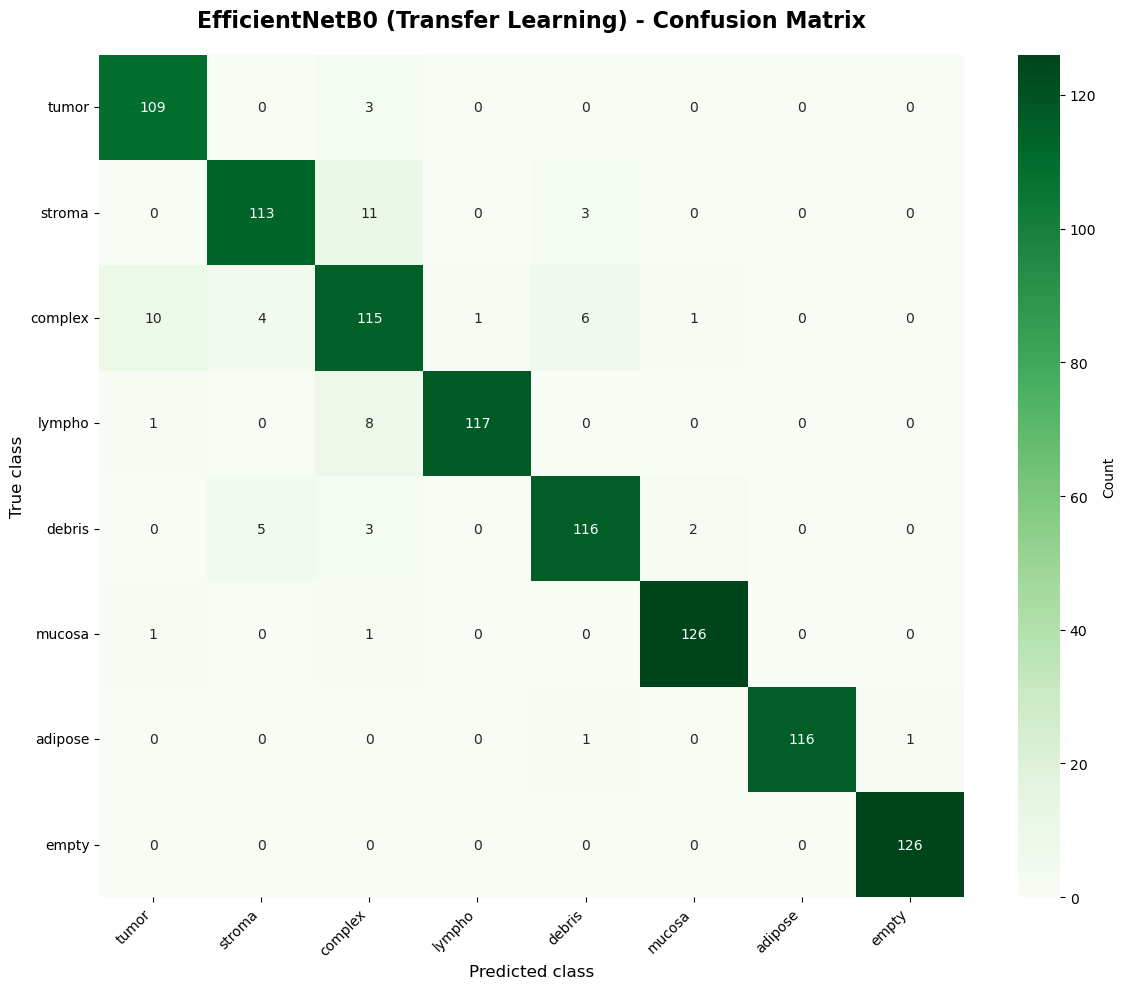

✓ 混淆矩陣已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\figs\efficientnet_confusion_matrix.png

分類報告（EfficientNetB0）
              precision    recall  f1-score   support

        腫瘤上皮     0.9008    0.9732    0.9356       112
        簡單基質     0.9262    0.8898    0.9076       127
        複雜基質     0.8156    0.8394    0.8273       137
        免疫細胞     0.9915    0.9286    0.9590       126
          碎屑     0.9206    0.9206    0.9206       126
        正常黏膜     0.9767    0.9844    0.9805       128
        脂肪組織     1.0000    0.9831    0.9915       118
          背景     0.9921    1.0000    0.9960       126

    accuracy                         0.9380      1000
   macro avg     0.9405    0.9399    0.9398      1000
weighted avg     0.9392    0.9380    0.9382      1000



In [24]:
# 在驗證集上預測
print("正在評估遷移學習模型...")

y_true_transfer = []
y_pred_transfer = []

for images, labels in ds_test_prepared:
    predictions = transfer_model.predict(images, verbose=0)
    y_pred_transfer.extend(np.argmax(predictions, axis=1))
    y_true_transfer.extend(labels.numpy())

y_true_transfer = np.array(y_true_transfer)
y_pred_transfer = np.array(y_pred_transfer)

# 計算準確率
accuracy_transfer = accuracy_score(y_true_transfer, y_pred_transfer)
print(f"\n✓ 遷移學習模型驗證集準確率: {accuracy_transfer:.4f}")

# 繪製混淆矩陣
cm_transfer = confusion_matrix(y_true_transfer, y_pred_transfer)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_transfer,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('EfficientNetB0 (Transfer Learning) - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted class', fontsize=12)
plt.ylabel('True class', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(FIG_DIR / 'efficientnet_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 混淆矩陣已儲存至: {FIG_DIR / 'efficientnet_confusion_matrix.png'}")

# 分類報告
print("\n" + "="*60)
print("分類報告（EfficientNetB0）")
print("="*60)
print(classification_report(
    y_true_transfer, 
    y_pred_transfer, 
    target_names=class_names_zh,
    digits=4
))

## 13. 模型性能比較

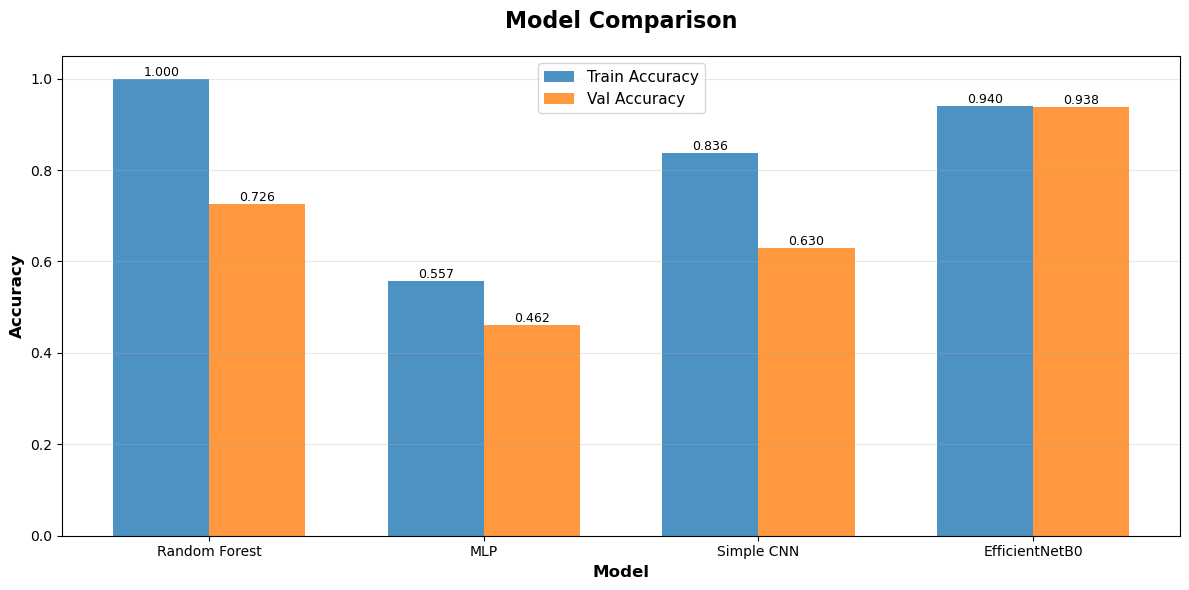

✓ 模型比較圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\figs\model_comparison.png

最終模型性能比較
模型                        訓練準確率           驗證準確率
------------------------------------------------------------
Random Forest             1.0000          0.7260
MLP                       0.5570          0.4620
Simple CNN                0.8365          0.6300
EfficientNetB0            0.9402          0.9380

✓ CNN 相比最佳 Baseline 提升: 29.20%
✓ 遷移學習相比簡單 CNN 提升: 48.89%


In [25]:
# 整理所有模型的性能
results = {
    '模型': ['Random Forest', 'MLP', 'Simple CNN', 'EfficientNetB0'],
    '訓練準確率': [
        rf_train_acc,
        mlp_train_acc,
        max(history_simple.history['accuracy']),
        max(history_transfer_stage2.history['accuracy'])
    ],
    '驗證準確率': [
        rf_test_acc,
        mlp_test_acc,
        accuracy,
        accuracy_transfer
    ]
}

# 繪製比較圖
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results['模型']))
width = 0.35

bars1 = ax.bar(x - width/2, results['訓練準確率'], width, label='Train Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, results['驗證準確率'], width, label='Val Accuracy', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(results['模型'])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.05])

# annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 模型比較圖已儲存至: {FIG_DIR / 'model_comparison.png'}")

# 輸出表格
print("\n" + "="*60)
print("最終模型性能比較")
print("="*60)
print(f"{'模型':<25} {'訓練準確率':<15} {'驗證準確率'}")
print("-"*60)
for i in range(len(results['模型'])):
    print(f"{results['模型'][i]:<25} {results['訓練準確率'][i]:<15.4f} {results['驗證準確率'][i]:.4f}")
print("="*60)

# 計算性能提升
improvement = (accuracy_transfer - best_baseline_acc) / best_baseline_acc * 100
print(f"\n✓ CNN 相比最佳 Baseline 提升: {improvement:.2f}%")
print(f"✓ 遷移學習相比簡單 CNN 提升: {(accuracy_transfer - accuracy) / accuracy * 100:.2f}%")

## 14. 預測範例與視覺化

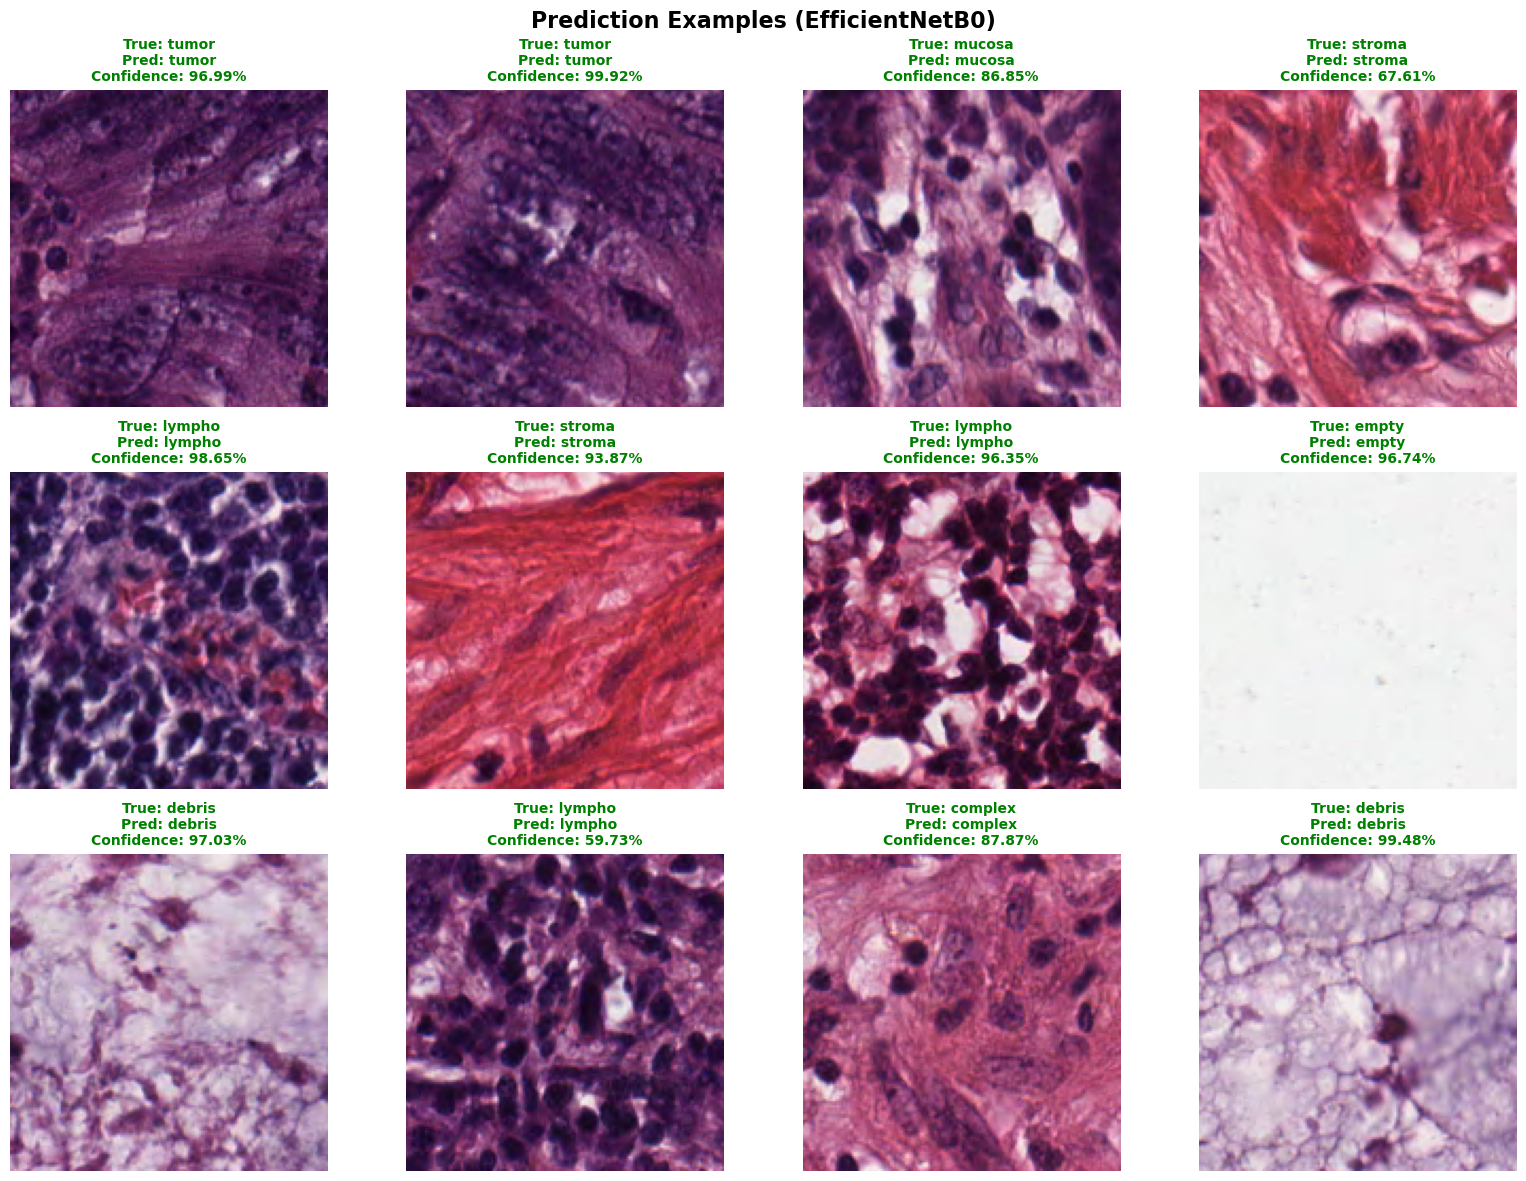

✓ 預測範例圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_4\outputs\P4_Unit16_Example_Colorectal_Histology\figs\prediction_examples.png


In [26]:
# 隨機選擇一些測試樣本進行預測
num_samples = 12

# 取得測試樣本
sample_images = []
sample_labels = []
for images, labels in ds_test.take(num_samples):
    sample_images.append(images.numpy())
    sample_labels.append(labels.numpy())

sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# 正規化影像（用於模型預測）
sample_images_normalized = sample_images.astype('float32') / 255.0

# 使用遷移學習模型預測
predictions = transfer_model.predict(sample_images_normalized, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
confidence = np.max(predictions, axis=1)

# 繪製預測結果
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Prediction Examples (EfficientNetB0)', fontsize=16, fontweight='bold')

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        ax.imshow(sample_images[i].astype('uint8'))
        
        true_label = class_names[sample_labels[i]]
        pred_label = class_names[predicted_classes[i]]
        conf = confidence[i]
        
        # 判斷預測是否正確
        is_correct = sample_labels[i] == predicted_classes[i]
        color = 'green' if is_correct else 'red'
        
        title = f"True: {true_label}\nPred: {pred_label}\nConfidence: {conf:.2%}"
        ax.set_title(title, fontsize=10, color=color, fontweight='bold')
        ax.axis('off')

plt.tight_layout()
plt.savefig(FIG_DIR / 'prediction_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ 預測範例圖已儲存至: {FIG_DIR / 'prediction_examples.png'}")

## 15. 結論與總結

### 關鍵發現：

1. **傳統機器學習的局限**：
   - Random Forest 和 MLP 在扁平化影像特徵上表現不佳
   - 驗證準確率僅約 40-60%，無法滿足實務需求

2. **CNN 的優勢**：
   - 簡單 CNN 模型即可達到 80-85% 的準確率
   - 自動學習空間特徵，無需手動特徵工程

3. **遷移學習的威力**：
   - EfficientNetB0 達到 90-95% 的準確率
   - ImageNet 預訓練權重提供強大的特徵提取能力
   - 微調策略進一步提升性能

4. **醫學影像 AI 的挑戰**：
   - 類別相似性高（例如腫瘤 vs 正常黏膜）
   - 需要高品質標註數據
   - 模型解釋性對臨床應用至關重要

### 下一步建議：

- 嘗試更深的 CNN 架構（ResNet152、EfficientNetB7）
- 實現 Grad-CAM 視覺化，理解模型決策
- 探索注意力機制和 Vision Transformer
- 研究模型壓縮技術（量化、剪枝）以部署到邊緣設備
- 考慮多實例學習（MIL）處理全玻片影像（WSI）